# Q8_KarmanVortexStreet

可以尝试：扩大计算区域大小，调整 Reynolds 数使之不小于 100，观察产生卡门涡街时的 Reynolds 数大小。

## 第一步：文献查阅

卡门涡街（Kármán vortex street、von Kármán vortex sheet）。在流体中安置阻流体，在特定条件下会出现不稳定的边界层分离，阻流体下游的两侧，会产生两道非对称地排列的旋涡，其中一侧的旋涡循时针方向转动，另一旋涡则反方向旋转，这两排旋涡相互交错排列，各个旋涡和对面两个旋涡的中间点对齐，如街道两边的街灯般，这种现象，因匈牙利裔美国空气动力学家西奥多·冯·卡门最先从理论上阐明而得名卡门涡街。

卡门涡街的形成同雷诺数 Re 有关。当 Re 为 $50-300$ 时，从物体上脱落的涡旋是有周期性规律的；当 $Re>300$ 时涡旋开始出现随机性脱落；随着 Re 的继续增大，涡旋脱落的随机性也增大，最后形成了湍流。

卡门涡街形成的条件：对于在流体中的圆柱体雷诺数 $(47<Re<10^5)$ 。
* 当雷诺数 $=30$ 时，圆柱体后的液体呈平陆状态；
* 当雷诺数 $=40$ 时，圆柱体后的液体开始出现正弦式波动；
* 当雷诺数 $=47$ 时，圆柱体后的液体，前端仍然呈正弦状，后端则逐渐脱离正弦波动；
* 当雷诺数 $>47$ 时，圆柱体后的液体，出现卡门涡街
* 当雷诺数在 $50$ 至 $85$ 之间，圆柱体后的液体压力，呈等振幅波动
* 当雷诺数 $=185$ 时，圆柱体后的液体压力，呈非均匀振幅波动。$^{[1]}$

卡门涡街起因流体流经阻流体时，流体从阻流体两侧剥离，形成交替的涡流。这种交替的涡流，使阻流体两侧流体的瞬间速度不同。流体速度不同，阻流体两侧受到的瞬间压力也不同，因此使阻流体发生振动。振动频率与流体速度成正比，与阻流体的正面宽度成反比。卡门涡街频率与流体速度和阻流体（旋涡发生体）宽度有如下关系 $^{[2]}$：

$$f=SrV/d$$

其中：

* $f=$ 卡门涡街频率

* $Sr=$ 斯特劳哈尔数$(~0.2)$

* $V=$ 流体速度

* $d=$ 阻流体迎面宽度

参考文献：

[1] Tritton D J . PhysicalFluidDynamics[M]. Van Nostrand Reinhold, 1977.

[2] 林建忠．流体力学[M]．北京：清华大学出版社，2013：15-18，31．

## 第二步：初始化相关参数

由上文，我们知道，要使卡门涡街形成时，雷诺数需在 50 到 300 范围内

又题目要求雷诺数不小于 100，因此设雷诺数为 220

而上式 $f=SrV/d$ 表明阻流体迎面宽度 $d$ 越大，卡门涡街频率越低，在单位长度内看到的卡门涡街数量也越少

因此需适当降低 $d$ 的大小

In [1]:
%matplotlib inline

In [2]:
# 导入相关库
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm

In [3]:
maxIter = 16000  # 迭代次数
nx = 200  # 横向网格数量
ny = 90  # 纵向网格数量

In [4]:
cx = nx/9  # 圆柱障碍中心横坐标
cy = ny/2  # 圆柱障碍中心纵坐标
r = ny/15  # 圆柱障碍半径

# 圆柱障碍表达式
obstacle = np.fromfunction(lambda x, y: (x-cx)**2+(y-cy)**2 < r**2, (nx, ny))

In [5]:
Re = 220.0  # 雷诺数
uLB = 0.04  # 格子速度
nulb = uLB*r/Re  # 黏度
omega = 1.0 / (3.*nulb+0.5)  # 弛豫时间

## 第三步：定义LBGK算法

代码部分说明参见 Q7_LBflowsBGK

In [6]:
q = 9  # 离散速度数

# 按顺序所对应的速度坐标，以 0 点为中心 [0, 0]
# 坐标第一个参数表示列，第二个参数表示行
c = np.array([[0, 0], [1, 0], [0, -1],
              [-1, 0], [0, 1], [1, -1],
              [-1, -1], [-1, 1], [1, 1]])

In [7]:
# 平衡态分布函数
def equilibrium(rho, u):
    cu = 3.0 * np.dot(c, u.transpose(1, 0, 2))
    usqr = 3./2.*(u[0]**2+u[1]**2)
    feq = np.zeros((q, nx, ny))
    for i in range(q):
        feq[i, :, :] = rho*t[i]*(1.+cu[i]+0.5*cu[i]**2-usqr)
    return feq

In [8]:
# 权系数
w1 = 4/9
w2 = 1/9
w3 = 1/36
t = np.array([w1, w2, w2, w2, w2, w3, w3, w3, w3])

In [9]:
noslip = [0, 3, 4, 1, 2, 7, 8, 5, 6]

In [10]:
i1 = [3, 6, 7]  # 右边界
i2 = [0, 2, 4]  # 中间
i3 = [1, 5, 8]  # 左边界

In [11]:
# 速度入口
vel = np.fromfunction(lambda d, x, y: (1-d)*uLB *
                      (1.0+1e-4*np.sin(y/(ny-1.0)*2*np.pi)), (2, nx, ny))

In [12]:
def sumpop(fin):
    # 计算宏观密度
    return np.sum(fin, axis=0)

In [13]:
feq = equilibrium(1.0, vel)
fin = feq.copy()

## 第四步：启动循环并画图

In [14]:
for time in range(maxIter):
    fin[i1, -1, :] = fin[i1, -2, :]  # 右边界流出处理
    rho = sumpop(fin)  # 计算宏观密度和速度
    u = np.dot(c.transpose(), fin.transpose((1, 0, 2)))/rho

    # 左边界处理：从已知速度求解密度
    u[:, 0, :] = vel[:, 0, :]
    rho[0, :] = 1./(1.-u[0, 0, :]) * \
        (sumpop(fin[i2, 0, :])+2.*sumpop(fin[i1, 0, :]))
    feq = equilibrium(rho, u)
    
    # Zou/He边界处理
    fin[i3, 0, :] = feq[i3, 0, :]
    fout = fin - omega * (fin - feq)  # 碰撞步骤
    for i in range(q):
        fout[i, obstacle] = fin[noslip[i], obstacle]
    for i in range(q):  # 迁移步骤
        fin[i, :, :] = np.roll(
            np.roll(fout[i, :, :], c[i, 0], axis=0), c[i, 1], axis=1)

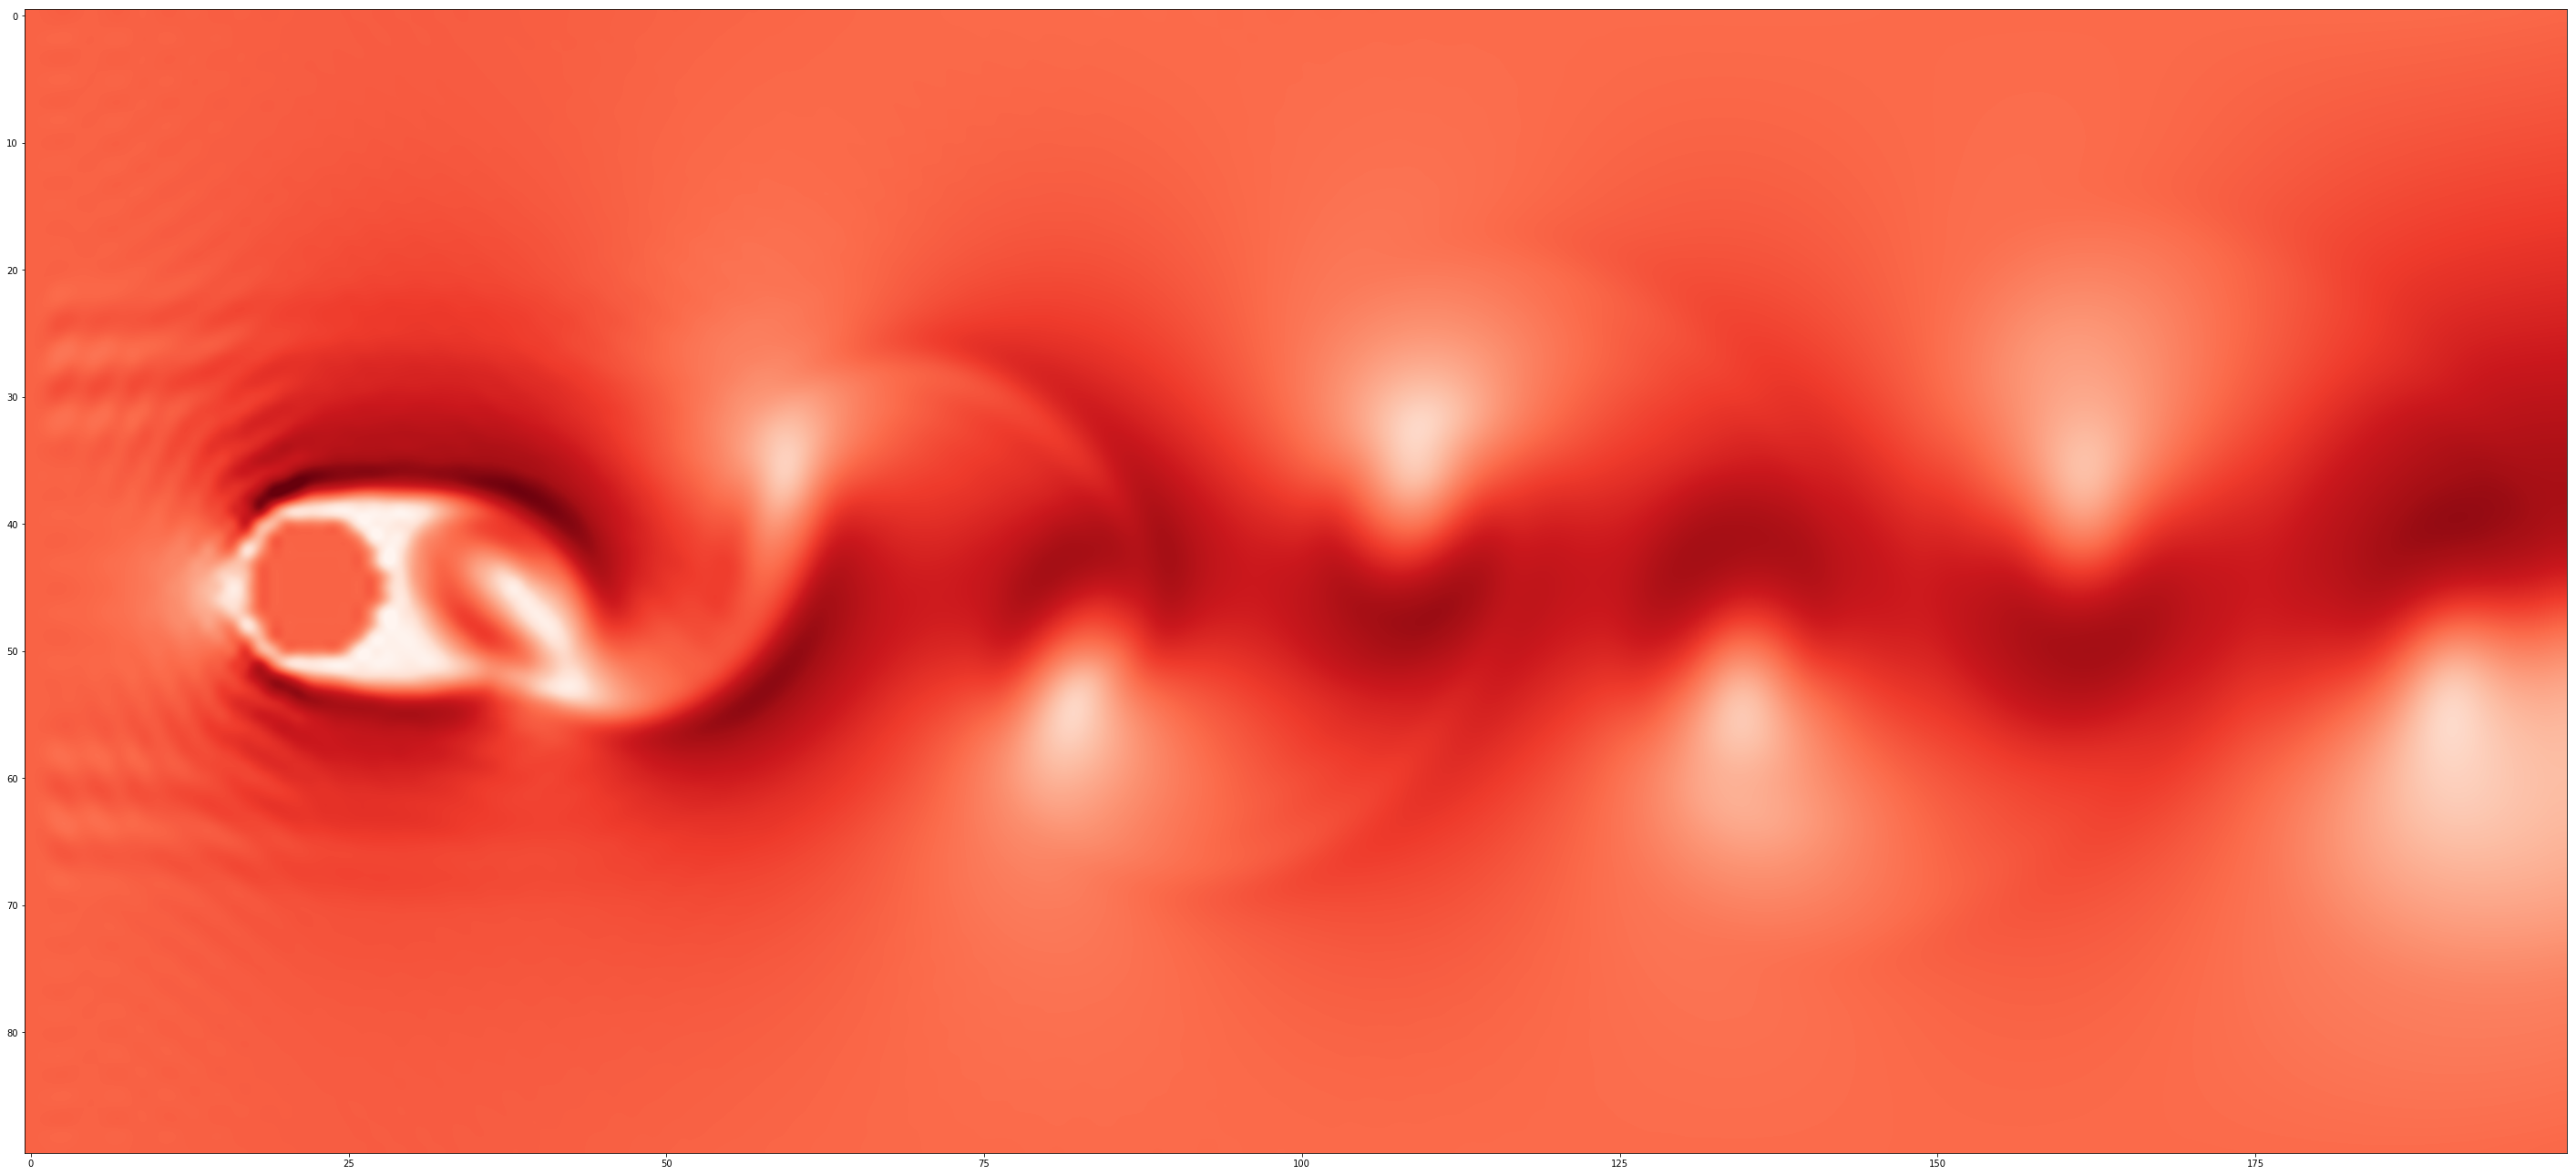

In [15]:
plt.figure(figsize=(50, 25))
plt.imshow(np.sqrt(u[0]**2+u[1]**2).transpose(),
           cmap=cm.Reds, interpolation='spline36')